In [1]:
from tdi import *

from scipy.interpolate import splrep, BSpline

In [36]:
Nz = 88
Rz = 0.455/2
Zcoil_GpA = (np.power(4/5, 3/2)*4*np.pi*(10**-7)*Nz/Rz)/(10**-4)

Nx = 88
Rx = 0.405/2
Xcoil_GpA = (np.power(4/5, 3/2)*4*np.pi*(10**-7)*Nx/Rx)/(10**-4)

def dI2ang(dI, θp=np.deg2rad(3.6)):
    sign = np.sign((dI + np.sin(2*θp)**2))
    return 2*θp - np.arcsin(sign*np.sqrt(np.abs((dI + np.sin(2*θp)**2))))

zCurArr = np.arange(-0.1, 0.15+0.01, 0.01)
zMagField = (zCurArr-0.025)*Zcoil_GpA

xCurArr = np.arange(-0.02, 0.1, 0.01)
xMagField = (xCurArr-0.05)*Xcoil_GpA

In [9]:
folder = "..\\Data\\Longitudinal_Field"
fileName = "ZCur"

SIF_REF_DATA = get_sif(folder, fileName, 0.08,1) 
CONTOURS, BINARIZE_MASK , SMOOTH_MASK_NORMED = get_contours(SIF_REF_DATA)

srf, srp, A1, A2, X1, X2 = get_splitting_ratio(SIF_REF_DATA, CONTOURS, BINARIZE_MASK )
trans1 , trans2 = srp/(srp+1), 1/(srp+1)
trans = [trans1, trans2]
AFref = [A1, A2]
Xref = [X1, X2]
θp = [np.deg2rad(3.538), np.deg2rad(3.801)]

longData = np.array([[get_values(get_sif(folder, fileName, cur, r+1), trans, θp, CONTOURS, BINARIZE_MASK, AFref, Xref) for r in range(5)] for cur in zCurArr])

In [10]:
folder = "..\\Data\\Transverse_Field"
fileName = "Xcur"

SIF_REF_DATA = get_sif(folder, fileName, 0.05,3) 
CONTOURS, BINARIZE_MASK , SMOOTH_MASK_NORMED = get_contours(SIF_REF_DATA)

srf, srp, A1, A2, X1, X2 = get_splitting_ratio(SIF_REF_DATA, CONTOURS, BINARIZE_MASK )
trans1 , trans2 = srp/(srp+1), 1/(srp+1)
trans = [trans1, trans2]
AFref = [A1, A2]
Xref = [X1, X2]
θp = [np.deg2rad(3.538), np.deg2rad(3.801)]

transData = np.array([[get_values(get_sif(folder, fileName, cur, r+1), trans, θp, CONTOURS, BINARIZE_MASK, AFref, Xref) for r in range(5)] for cur in xCurArr])

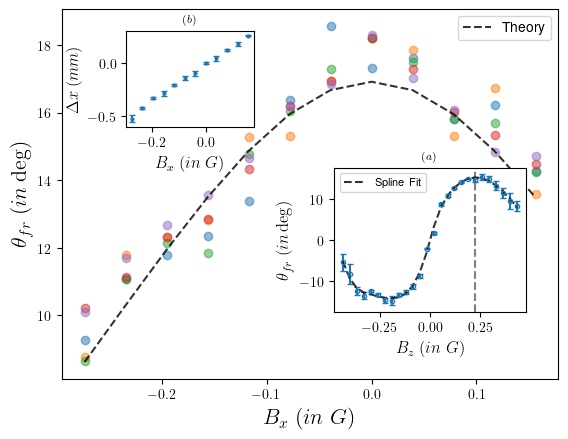

In [143]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

zθfr1 = dI2ang(longData[:,:,1], θp=np.deg2rad(3.538))
zθfr2 = dI2ang(longData[:,:,2], θp=np.deg2rad(3.801))
zθfr = np.rad2deg((zθfr1 - zθfr2)/2)

xθfr1 = dI2ang(transData[:,:,1], θp=np.deg2rad(3.538))
xθfr2 = dI2ang(transData[:,:,2], θp=np.deg2rad(3.801))
xθfr = np.rad2deg((xθfr1 - xθfr2)/2)

spl = splrep(zMagField, np.nanmean(zθfr, axis=1), s=10)
splModel = BSpline(*spl)

xshift = -transData[:,:,3]

def proj_m(Bx, Bz=zMagField[-7]):
    return splModel(np.sqrt(Bz**2+Bx**2))*0.25/np.sqrt(Bz**2+Bx**2)


fig, ax = plt.subplots()

left1, bottom1, width1, height1 = [0.55, 0.25, 0.3, 0.3]
axin1 = fig.add_axes([left1, bottom1, width1, height1])

left2, bottom2, width2, height2 = [0.225, 0.635, 0.2, 0.2]
axin2 = fig.add_axes([left2, bottom2, width2, height2])

axin1.axvline(zMagField[-7], ls= '--', c='gray')
#axin.plot(zMagField, np.mean(zθfr, axis=1), 'o', alpha=0.5, ms=3)
axin1.errorbar(zMagField, np.nanmean(zθfr, axis=1), np.nanstd(zθfr, axis=1), ms=3, fmt='o', capsize=2, mfc='None')
axin1.plot(zMagField, splModel(zMagField), 'k--', alpha=0.8,  label="Spline Fit")
axin1.legend(fontsize=8)
axin1.set_xlabel("$ B_z \ (in \ G)$", fontsize=12)
axin1.set_ylabel("$ \\theta_{fr}  \ (in \\deg)$", fontsize=12)
axin1.set_title("$(a)$", fontsize=8)

ax.plot(xMagField, xθfr, 'o', alpha=0.5)
ax.plot(xMagField, proj_m(xMagField), 'k--', alpha=0.8, label="Theory")
ax.legend()
ax.set_xlabel("$ B_x  \ (in \ G)$", fontsize=16)
ax.set_ylabel("$ \\theta_{fr}  \ (in \\deg)$", fontsize=16)

axin2.errorbar(xMagField, np.nanmean(xshift, axis=1), np.nanstd(xshift, axis=1), fmt='o', ms=2, capsize=2)
axin2.set_xlabel("$ B_x \ (in \ G)$", fontsize=12)
axin2.set_ylabel("$ \\Delta  x \ ( mm)$", fontsize=12)
axin2.set_title("$(b)$", fontsize=8)
plt.savefig("../Graphs/transverseField.pdf", bbox_inches='tight')
plt.show()